# 📘 Titanic Linear Regression (CSV) + EDA — v3
**Fix:** Drop rows with missing target `Age` before splitting (models cannot train with NaN targets).


## Setup & Data Loading

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('titanic_full_dataset.csv')
print(df.shape)
df.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,2,"Wilson, Mrs. Ella",female,60.202315,0,0,XIB 650336,20.2405,NaN,S
1,2,0,3,"Thompson, Mrs. Nellie",female,21.519991,0,3,19 51980,10.7555,NaN,S
2,3,0,3,"Thomas, Mr. James",male,40.389335,0,0,M03 590283,12.6781,NaN,S
3,4,0,3,"Wilson, Miss. Annie",female,34.190096,0,0,E1 51565,18.9832,NaN,S
4,5,0,1,"Martin, Mr. Louis",male,48.224378,2,0,58J 335,72.4514,F38,S


## EDA — Structure & Missing Values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          718 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        178 non-null    object 
 11  Embarked     880 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
df.isna().sum().sort_values(ascending=False)

Cabin          713
Age            173
Embarked        11
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [15]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.246914,0.431458,0.0,0.0,0.0,0.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.292929,0.849683,1.0,1.0,3.0,3.0,3.0
Name,891,580,"Garcia, Mr. Charles",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,718.0,NaN,NaN,NaN,30.130276,13.651298,0.42,20.964952,29.690353,39.408706,73.928479
SibSp,891.0,NaN,NaN,NaN,0.447811,0.939952,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.434343,0.952176,0.0,0.0,0.0,0.0,6.0
Ticket,891,891,XIB 650336,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,34.77663,36.444109,4.1317,12.04065,16.7767,44.79255,214.0078


## EDA — Distributions & Simple Relationships

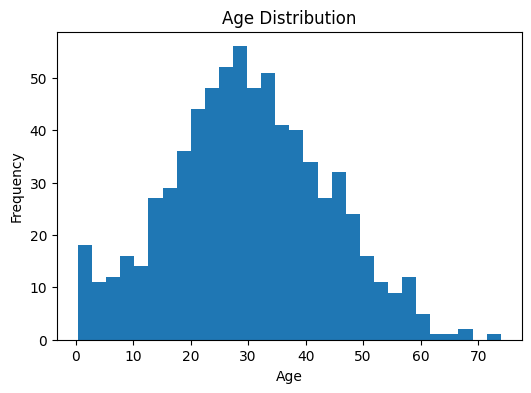

In [16]:

plt.figure(figsize=(6,4))
df['Age'].plot(kind='hist', bins=30)
plt.xlabel('Age'); plt.title('Age Distribution'); plt.show()


/var/folders/0q/b4wqh1gs5bvdwfddd5n47_wr0000gn/T/ipykernel_20861/2825958873.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df['Pclass'].dropna().unique()))


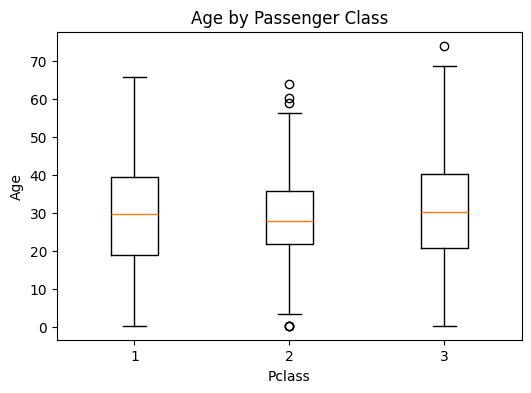

In [17]:

plt.figure(figsize=(6,4))
groups = [df.loc[df['Pclass']==c, 'Age'].dropna() for c in sorted(df['Pclass'].dropna().unique())]
plt.boxplot(groups, labels=sorted(df['Pclass'].dropna().unique()))
plt.xlabel('Pclass'); plt.ylabel('Age'); plt.title('Age by Passenger Class'); plt.show()


## Target & Features (with target dropna)

In [18]:

cols = ['Age','Pclass','Sex','SibSp','Parch','Fare','Embarked']
data = df[cols].copy()
data['Alone'] = ((data['SibSp'].fillna(0) + data['Parch'].fillna(0)) == 0).astype(int)

# Drop rows where the TARGET is NaN
data = data.dropna(subset=['Age']).reset_index(drop=True)

y = data['Age']
X = data.drop(columns=['Age'])

num_features = ['Pclass','SibSp','Parch','Fare']
cat_features = ['Sex','Embarked','Alone']
print('Rows after dropping NaN Age:', len(data))


Rows after dropping NaN Age: 718


## Preprocessing + Train/Test

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train & Evaluate

In [20]:

model = Pipeline([('preprocess', preprocess), ('regressor', LinearRegression())])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from math import sqrt
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print({'MAE': round(mae,3), 'RMSE': round(rmse,3), 'R2': round(r2,3)})


{'MAE': 11.567, 'RMSE': 13.983, 'R2': 0.002}


## Plots — Predicted vs Actual & Residuals

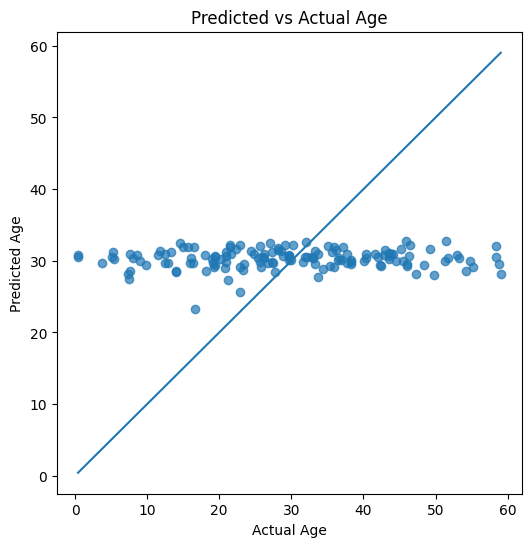

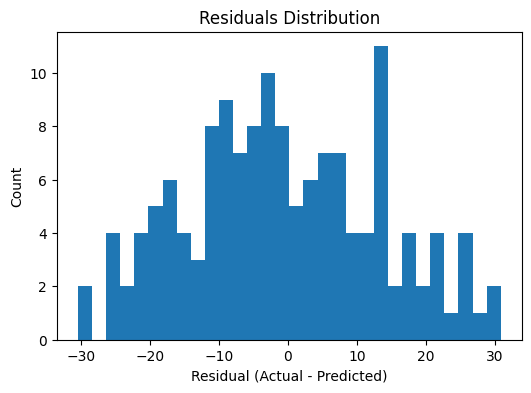

In [21]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = np.nanmin([y_test.min(), y_pred.min()]), np.nanmax([y_test.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx])
plt.xlabel('Actual Age'); plt.ylabel('Predicted Age'); plt.title('Predicted vs Actual Age'); plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel('Residual (Actual - Predicted)'); plt.ylabel('Count'); plt.title('Residuals Distribution'); plt.show()


## Coefficients

In [22]:

ct = model.named_steps['preprocess']
ohe = ct.named_transformers_['cat'].named_steps['onehot']
num_names = num_features
cat_names = list(ohe.get_feature_names_out(cat_features))
all_feature_names = num_names + cat_names

coefs = model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'feature': all_feature_names, 'coef': coefs}).sort_values('coef', ascending=False)
coef_df.head(12)


,feature,coef
6,Embarked_C,0.666404
5,Sex_male,0.453691
7,Embarked_Q,0.350458
9,Alone_0,0.200385
1,SibSp,0.052737
2,Parch,-0.106501
10,Alone_1,-0.200385
4,Sex_female,-0.453691
0,Pclass,-0.602676
8,Embarked_S,-1.016862
